In [1]:
from build_crime_sanit import *

In [123]:
import build_crime_sanit
reload(build_crime_sanit)
from build_crime_sanit import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
dat = pd.read_csv("data_ready.csv")
dat['inspection_date'] = pd.to_datetime(dat['inspection_date'])
start = dat['inspection_date'].min()
end = pd.Timestamp('2015-12-31')

In [4]:
crime, sanit = main(start, end, 100)

https://data.cityofchicago.org/resource/6zsd-86xi.json?$where=date>='2010-01-04T00:00:00' AND date<='2015-12-31T00:00:00'&$limit=10000000
Crime records received: 1897851
https://data.cityofchicago.org/resource/kcdz-f29q.json?$where=creation_date>='2010-01-04T00:00:00' AND creation_date<='2015-12-31T00:00:00'&$limit=10000000
Sanitation records received: 93738


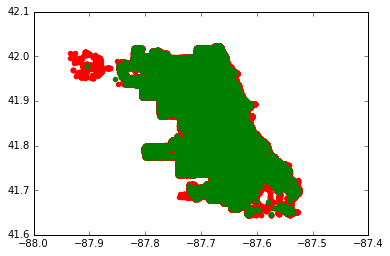

In [104]:
crime_sub = crime[(crime['longitude'] >= -88.5) & (crime['latitude'] >= 41)]
sanit_sub = sanit[(sanit['longitude'] >= -88.5) & (sanit['latitude'] >= 41)]

plt.figure()
plt.scatter(crime_sub['longitude'], crime_sub['latitude'], color='red')
plt.scatter(sanit_sub['longitude'], sanit_sub['latitude'], color='green')
plt.show()

In [127]:
nbins_x = 25

lat = crime_sub['latitude']
lon = crime_sub['longitude']

latm = lat.min(), lat.max()
lonm = lon.min(), lon.max()

lat_space, lon_space, grid \
        = build_grid(latm, lonm, nbins_x)

dicts = []

for pt in grid:
    row = dict(pt_x=pt[0], pt_y=pt[1], 
               crime=subset_count(crime_sub, pt, lat_space, lon_space),
               sanit=subset_count(sanit_sub, pt, lat_space, lon_space))
    dicts.append(row)

df = pd.DataFrame(dicts)

In [137]:
import seaborn as sns

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [318]:
plt.rc('font', family='serif') 

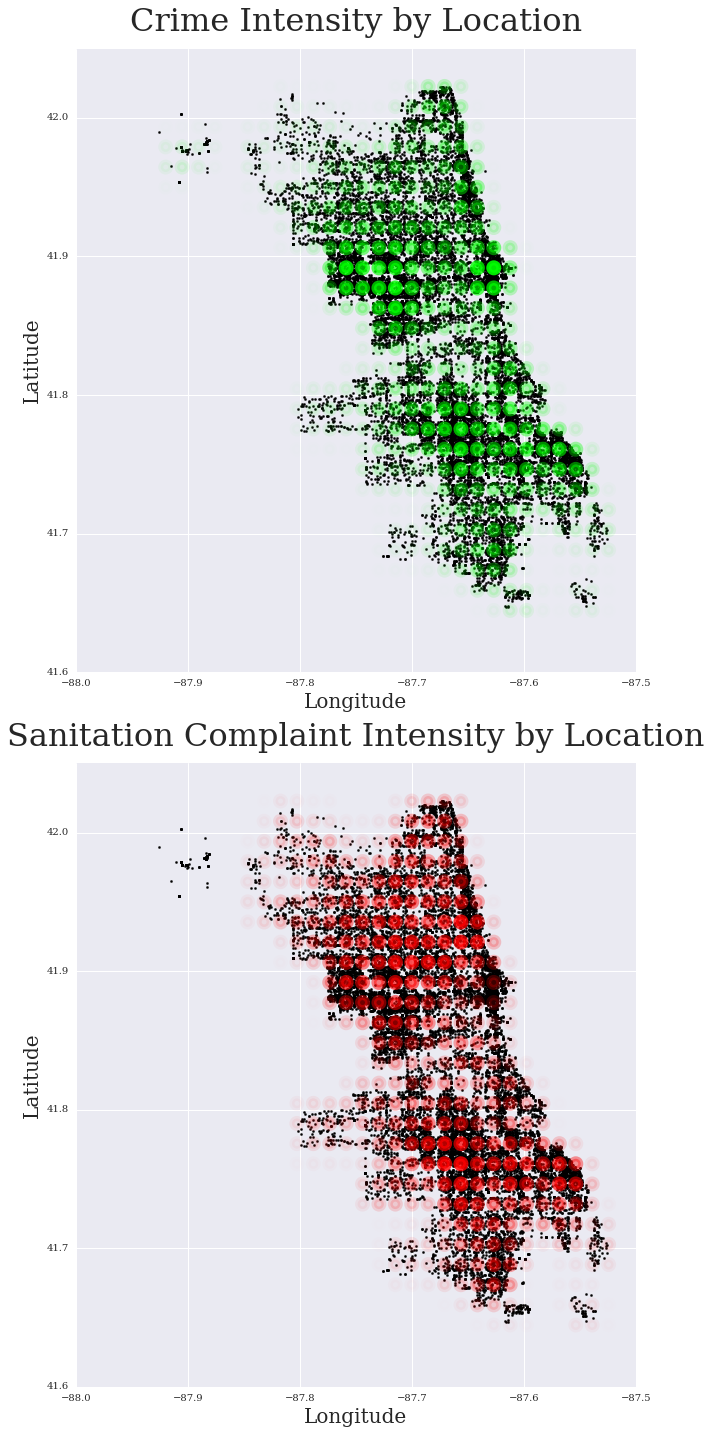

In [326]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))

colors = np.zeros((len(df), 4))
colors[:, 1] = 1
colors[:, 3] = df['crime'] / df['crime'].sum()*80

ax[0].set_title("Crime Intensity by Location", fontsize=32, y=1.02)
ax[0].scatter(crime_sub.head(n=20000)['longitude'],
            crime_sub.head(n=20000)['latitude'],
            marker='.', color='black')
ax[0].scatter(df['pt_x'], df['pt_y'],  color=colors, s=100, lw=5)
ax[0].set_xlabel("Longitude", fontsize=20)
ax[0].set_ylabel("Latitude", fontsize=20)

colors = np.zeros((len(df), 4))
colors[:, 0] = 1
colors[:, 3] = df['sanit'] / df['sanit'].sum()*90

ax[1].set_title("Sanitation Complaint Intensity by Location", fontsize=32, y=1.02)
ax[1].scatter(crime_sub.head(n=20000)['longitude'],
            crime_sub.head(n=20000)['latitude'],
            marker='.', color='black')
ax[1].scatter(df['pt_x'], df['pt_y'], color=colors, s=100, lw=5)
ax[1].set_xlabel("Longitude", fontsize=20)
ax[1].set_ylabel("Latitude", fontsize=20)

plt.tight_layout()
plt.savefig('poster/figures/both_col.pdf')

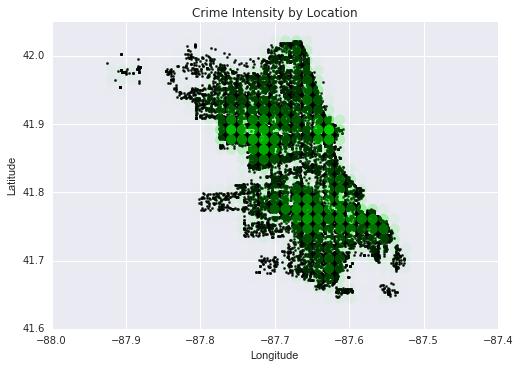

In [291]:
colors = np.zeros((len(df), 4))
colors[:, 1] = 1
colors[:, 3] = df['crime'] / df['crime'].sum()*70

plt.figure()
plt.title("Crime Intensity by Location")
plt.scatter(crime_sub.head(n=20000)['longitude'],
            crime_sub.head(n=20000)['latitude'],
            marker='.', color='black')
plt.scatter(df['pt_x'], df['pt_y'],  color=colors, s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig('poster/figures/crime.pdf')

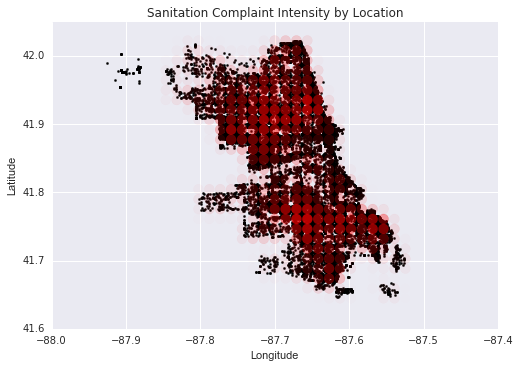

In [292]:
colors = np.zeros((len(df), 4))
colors[:, 0] = 1
colors[:, 3] = df['sanit'] / df['sanit'].sum()*80

plt.figure()
plt.title("Sanitation Complaint Intensity by Location")
plt.scatter(crime_sub.head(n=20000)['longitude'],
            crime_sub.head(n=20000)['latitude'],
            marker='.', color='black')
plt.scatter(df['pt_x'], df['pt_y'], color=colors, s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig('poster/figures/sanitation.pdf')

In [190]:
from download import get_loc, distance
import download
reload(download)
from download import get_loc, distance

In [193]:
def find_closest(row, points):
    
    latlon = get_loc(row[1])    
        
    distances = np.array([distance(latlon, pt) for pt in points])
    
    return list(points[distances.argmin()])

In [196]:
closest = [find_closest(r, grid) for r in dat.iterrows()]

In [208]:
nearest = pd.DataFrame(closest)
nearest.columns = ['pt_x', 'pt_y']

In [271]:
def get_crime(row, column='crime'):
    x = row['pt_x']    
    y = row['pt_y']
    match = df[(df['pt_x'] == x) & (df['pt_y'] == y)]
    
    return match[column].values[0]

In [272]:
crime_counts = nearest.apply(get_crime, args=('crime',), axis=1)
sanit_counts = nearest.apply(get_crime, args=('sanit',), axis=1)

In [280]:
new_dat = dat.copy()
del new_dat['point_crime_count']
del new_dat['point_sanit_count']
new_dat['crime'] = crime_counts
new_dat['sanitation'] = sanit_counts


In [282]:
new_dat.to_csv('data_with_crime_sanit.csv')

In [283]:
new_dat.loc[:, ['crime', 'sanitation']].to_csv('crime_sanit.csv')

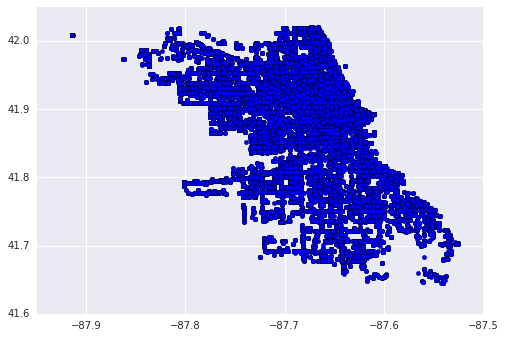

In [189]:
plt.figure()
plt.scatter(dat['longitude'], dat['latitude'])
plt.show()